In [ ]:
!pip install --user -U nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 18.2 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [ ]:
import nltk
nltk.download('cmudict')
all_dictionary = nltk.corpus.cmudict.dict()

[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Unzipping corpora/cmudict.zip.


# Implementation of Hidden Markov Models

In [ ]:
class HiddenMarkovModel:
    '''
    Class implementation of Hidden Markov Models.
    '''

    def __init__(self, A, O):
        '''
        Initializes an HMM. Assumes the following:
            - States and observations are integers starting from 0. 
            - There is a start state (see notes on A_start below). There
              is no integer associated with the start state, only
              probabilities in the vector A_start.
            - There is no end state.
        Arguments:
            A:          Transition matrix with dimensions L x L.
                        The (i, j)^th element is the probability of
                        transitioning from state i to state j. Note that
                        this does not include the starting probabilities.
            O:          Observation matrix with dimensions L x D.
                        The (i, j)^th element is the probability of
                        emitting observation j given state i.
        Parameters:
            L:          Number of states.
            
            D:          Number of observations.
            
            A:          The transition matrix.
            
            O:          The observation matrix.
            
            A_start:    Starting transition probabilities. The i^th element
                        is the probability of transitioning from the start
                        state to state i. For simplicity, we assume that
                        this distribution is uniform.
        '''

        self.L = len(A)
        self.D = len(O[0])
        self.A = A
        self.O = O
        self.A_start = [1. / self.L for _ in range(self.L)]


    def viterbi(self, x):
        '''
        Uses the Viterbi algorithm to find the max probability state 
        sequence corresponding to a given input sequence.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
        Returns:
            max_seq:    State sequence corresponding to x with the highest
                        probability.
        '''
        M = len(x)      # Length of sequence.

        # The (i, j)^th elements of probs and seqs are the max probability
        # of the prefix of length i ending in state j and the prefix
        # that gives this probability, respectively.
        #
        # For instance, probs[1][0] is the probability of the prefix of
        # length 1 ending in state 0.
        probs = [[0. for _ in range(self.L)] for _ in range(M + 1)]
        seqs = [['' for _ in range(self.L)] for _ in range(M + 1)]

        for state in range(self.L):
          probs[1][state] = self.A_start[state] * self.O[state][x[0]]
          seqs[1][state] = str(state)
        
        for k in range(2, M + 1):
          for a in range(self.L): #column
            max_probability = 0
            max_prefix = ""
            for yj in range(self.L): #row
              yja = probs[k - 1][yj] * self.A[yj][a] * self.O[a][x[k - 1]]
              if yja > max_probability:
                max_probability = yja
                max_prefix = seqs[k -  1][yj]
            probs[k][a] = max_probability
            seqs[k][a] = max_prefix + str(a)
        
        max_val = 0
        max_index = -1
        for i in range(self.L):
          if probs[M][i] > max_val:
            max_val = probs[M][i]
            max_index = i

        max_seq = seqs[M][max_index]
        return max_seq


    def forward(self, x, normalize=False):
        '''
        Uses the forward algorithm to calculate the alpha probability
        vectors corresponding to a given input sequence.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
            normalize:  Whether to normalize each set of alpha_j(i) vectors
                        at each i. This is useful to avoid underflow in
                        unsupervised learning.
        Returns:
            alphas:     Vector of alphas.
                        The (i, j)^th element of alphas is alpha_j(i),
                        i.e. the probability of observing prefix x^1:i
                        and state y^i = j.
                        e.g. alphas[1][0] corresponds to the probability
                        of observing x^1:1, i.e. the first observation,
                        given that y^1 = 0, i.e. the first state is 0.
        '''

        M = len(x)      # Length of sequence.
        alphas = np.zeros((M + 1, self.L))

        for state in range(self.L):
          alphas[1][state] = self.A_start[state] * self.O[state][x[0]]

        for i in range(2, M + 1):
          for z in range(self.L):
            total = 0
            for j in range(self.L):
              total += alphas[i - 1][j] * self.A[j][z]
            alphas[i][z] = self.O[z][x[i-1]] * total
          if normalize:
            alphas[i] /= sum(alphas[i])

        return alphas


    def backward(self, x, normalize=False):
        '''
        Uses the backward algorithm to calculate the beta probability
        vectors corresponding to a given input sequence.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
            normalize:  Whether to normalize each set of alpha_j(i) vectors
                        at each i. This is useful to avoid underflow in
                        unsupervised learning.
        Returns:
            betas:      Vector of betas.
                        The (i, j)^th element of betas is beta_j(i), i.e.
                        the probability of observing prefix x^(i+1):M and
                        state y^i = j.
                        e.g. betas[M][0] corresponds to the probability
                        of observing x^M+1:M, i.e. no observations,
                        given that y^M = 0, i.e. the last state is 0.
        '''

        M = len(x)      # Length of sequence.
        betas = np.zeros((M + 1, self.L))

        for state in range(self.L):
          betas[M][state] = 1

        for i in range(M - 1, 0, -1):
          for z in range(self.L):
            betas[i][z] = 0
            for j in range(self.L):
              betas[i][z] += betas[i + 1][j] * self.A[z][j] * self.O[j][x[i]]
          if normalize:
            betas[i] /= sum(betas[i])
        return betas


    def supervised_learning(self, X, Y):
        '''
        Trains the HMM using the Maximum Likelihood closed form solutions
        for the transition and observation matrices on a labeled
        datset (X, Y). Note that this method does not return anything, but
        instead updates the attributes of the HMM object.
        Arguments:
            X:          A dataset consisting of input sequences in the form
                        of lists of variable length, consisting of integers 
                        ranging from 0 to D - 1. In other words, a list of
                        lists.
            Y:          A dataset consisting of state sequences in the form
                        of lists of variable length, consisting of integers 
                        ranging from 0 to L - 1. In other words, a list of
                        lists.
                        Note that the elements in X line up with those in Y.
        '''
        for row in range(self.L):
          for col in range(self.L):

            # iterate through the X and Y matrix to get the respected input/ state sequences 
            num = 0
            denom = 0

            for x_ind in range(len(Y)):
              for y_ind in range(1, len(Y[x_ind])):
                
                # yi =b∧yi =a]
                if Y[x_ind][y_ind] == col and Y[x_ind][y_ind - 1] == row:
                  num += 1
                if Y[x_ind][y_ind - 1] == row:
                  denom += 1
        

            prob_update_A = num/denom
            self.A[row][col] = prob_update_A

        # Calculate each element of O using the M-step formulas.
        
        for row in range(self.L):
          for col in range(self.D):

            # iterate through the X and Y matrix to get the respected input/ state sequences 
            num = 0
            denom = 0

            for x_ind in range(len(X)):
              for y_ind in range(len(Y[x_ind])):
                
                # yi =b∧yi =a]
                if X[x_ind][y_ind] == col and Y[x_ind][y_ind] == row:
                  num += 1
                if Y[x_ind][y_ind] == row:
                  denom += 1
        
            prob_update_observation = num/denom
            self.O[row][col] = prob_update_observation


    def unsupervised_learning(self, X, N_iters):
        '''
        Trains the HMM using the Baum-Welch algorithm on an unlabeled
        datset X. Note that this method does not return anything, but
        instead updates the attributes of the HMM object.
        Arguments:
            X:          A dataset consisting of input sequences in the form
                        of variable-length lists, consisting of integers 
                        ranging from 0 to D - 1. In other words, a list of
                        lists.
            N_iters:    The number of iterations to train on.
        '''
        for _ in range(N_iters):
          A_numerator = np.zeros((self.L, self.L))
          O_numerator = np.zeros((self.L, self.D))
          A_denominator = np.zeros((self.L, 1))
          O_denominator = np.zeros((self.L, 1))

          for x in X:
            M = len(x)
            alphas = self.forward(x, True)
            betas = self.backward(x, True)
            for t in range(1, M):
              e_step = np.zeros((self.L, self.L))
              sum = 0
              for i in range (self.L):
                for j in range (self.L):
                  val = alphas[t][i] * self.A[i][j] * self.O[j][x[t]] * betas[t + 1][j]
                  e_step[i][j] = val
                  sum += val
              e_step /= sum
              A_numerator += e_step
            
            for t in range(1, M + 1):
              A_curr = np.zeros((self.L, 1))
              O_curr = np.zeros((self.L, 1))
              sum = 0
              for i in range (self.L):
                val = alphas[t][i] * betas[t][i]
                A_curr[i] = val
                O_curr[i] = val
                sum += val
              A_curr /= sum
              O_curr /= sum
              for i in range (self.L):
                if t != M:
                  A_denominator[i] += A_curr[i]
                O_denominator[i] += O_curr[i]
                O_numerator[i][x[t - 1]] += O_curr[i]

          self.A = A_numerator/A_denominator
          self.O = O_numerator/O_denominator

    def generate_emission(self, M, seed=None):
        '''
        Generates an emission of length M, assuming that the starting state
        is chosen uniformly at random. 
        Arguments:
            M:          Length of the emission to generate.
        Returns:
            emission:   The randomly generated emission as a list.
            states:     The randomly generated states as a list.
        '''

        # (Re-)Initialize random number generator
        rng = np.random.default_rng(seed=seed)

        emission = []
        states = []

        state = rng.choice(range(self.L))
        for _ in range(M):
          emission.append(rng.choice(range(self.D), p = self.O[state]))
          states.append(state)
          state = rng.choice(range(self.L), p = self.A[state])

        return emission, states
    
    def generate_emission_sonnet(self, M, syllable_dictionary, word_idx, all_dict, seed=None):
        # (Re-)Initialize random number generator
        rng = np.random.default_rng(seed=seed)

        emission = []
        states = []

        num_syllables = 0

        state = rng.choice(range(self.L))
        prev = 0
        while num_syllables != M:
          curr_emission = rng.choice(range(self.D), p = self.O[state])
          w = list(word_idx.keys())[list(word_idx.values()).index(curr_emission)]
          get_stresses = stress_syllables(all_dict[w][0])
          prev = get_stresses[len(get_stresses) - 1]
          poss = syllable_dictionary[w]
          fill = True
          if len(poss[1]) > 1 and poss[1][0] + num_syllables == M:
            emission.append(curr_emission)
            states.append(state)
            state = rng.choice(range(self.L), p = self.A[state])
            num_syllables += poss[1][0]
            fill = False
          if fill:
            val = np.random.choice(poss[0])
            if num_syllables + val <= M:
              emission.append(curr_emission)
              states.append(state)
              state = rng.choice(range(self.L), p = self.A[state])
              num_syllables += val
        return emission, states

    def generate_emission_haiku(self, M, syllable_dictionary, word_idx, seed=None):
        # (Re-)Initialize random number generator
        rng = np.random.default_rng(seed=seed)

        emission = []
        states = []

        num_syllables = 0

        state = rng.choice(range(self.L))
        while num_syllables != M:
          curr_emission = rng.choice(range(self.D), p = self.O[state])
          w = list(word_idx.keys())[list(word_idx.values()).index(curr_emission)]
          poss = syllable_dictionary[w]
          fill = True
          if len(poss[1]) > 1 and poss[1][0] + num_syllables == M:
            emission.append(curr_emission)
            states.append(state)
            state = rng.choice(range(self.L), p = self.A[state])
            num_syllables += poss[1][0]
            fill = False
          if fill:
            val = np.random.choice(poss[0])
            if num_syllables + val <= M:
              emission.append(curr_emission)
              states.append(state)
              state = rng.choice(range(self.L), p = self.A[state])
              num_syllables += val
        return emission, states

    def probability_alphas(self, x):
        '''
        Finds the maximum probability of a given input sequence using
        the forward algorithm.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
        Returns:
            prob:       Total probability that x can occur.
        '''

        # Calculate alpha vectors.
        alphas = self.forward(x)

        # alpha_j(M) gives the probability that the state sequence ends
        # in j. Summing this value over all possible states j gives the
        # total probability of x paired with any state sequence, i.e.
        # the probability of x.
        prob = sum(alphas[-1])
        return prob


    def probability_betas(self, x):
        '''
        Finds the maximum probability of a given input sequence using
        the backward algorithm.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
        Returns:
            prob:       Total probability that x can occur.
        '''

        betas = self.backward(x)

        # beta_j(1) gives the probability that the state sequence starts
        # with j. Summing this, multiplied by the starting transition
        # probability and the observation probability, over all states
        # gives the total probability of x paired with any state
        # sequence, i.e. the probability of x.
        prob = sum([betas[1][j] * self.A_start[j] * self.O[j][x[0]] \
                    for j in range(self.L)])

        return prob


def supervised_HMM(X, Y):
    '''
    Helper function to train a supervised HMM. The function determines the
    number of unique states and observations in the given data, initializes
    the transition and observation matrices, creates the HMM, and then runs
    the training function for supervised learning.
    Arguments:
        X:          A dataset consisting of input sequences in the form
                    of lists of variable length, consisting of integers 
                    ranging from 0 to D - 1. In other words, a list of lists.
        Y:          A dataset consisting of state sequences in the form
                    of lists of variable length, consisting of integers 
                    ranging from 0 to L - 1. In other words, a list of lists.
                    Note that the elements in X line up with those in Y.
    '''
    # Make a set of observations.
    observations = set()
    for x in X:
        observations |= set(x)

    # Make a set of states.
    states = set()
    for y in Y:
        states |= set(y)
    
    # Compute L and D.
    L = len(states)
    D = len(observations)

    # Randomly initialize and normalize matrix A.
    A = [[random.random() for i in range(L)] for j in range(L)]

    for i in range(len(A)):
        norm = sum(A[i])
        for j in range(len(A[i])):
            A[i][j] /= norm
    
    # Randomly initialize and normalize matrix O.
    O = [[random.random() for i in range(D)] for j in range(L)]

    for i in range(len(O)):
        norm = sum(O[i])
        for j in range(len(O[i])):
            O[i][j] /= norm

    # Train an HMM with labeled data.
    HMM = HiddenMarkovModel(A, O)
    HMM.supervised_learning(X, Y)

    return HMM

def unsupervised_HMM(X, n_states, N_iters, seed=None):
    '''
    Helper function to train an unsupervised HMM. The function determines the
    number of unique observations in the given data, initializes
    the transition and observation matrices, creates the HMM, and then runs
    the training function for unsupervised learing.
    Arguments:
        X:          A dataset consisting of input sequences in the form
                    of lists of variable length, consisting of integers 
                    ranging from 0 to D - 1. In other words, a list of lists.
        n_states:   Number of hidden states to use in training.
        
        N_iters:    The number of iterations to train on.
        rng:        The random number generator for reproducible result.
                    Default to RandomState(1).
    '''
    # Initialize random number generator
    rng = np.random.default_rng(seed=seed)

    # Make a set of observations.
    observations = set()
    for x in X:
        observations |= set(x)
    
    # Compute L and D.
    L = n_states
    D = len(observations)

    # Randomly initialize and normalize matrix A.
    A = [[rng.random() for i in range(L)] for j in range(L)]

    for i in range(len(A)):
        norm = sum(A[i])
        for j in range(len(A[i])):
            A[i][j] /= norm
    
    # Randomly initialize and normalize matrix O.
    O = [[rng.random() for i in range(D)] for j in range(L)]

    for i in range(len(O)):
        norm = sum(O[i])
        for j in range(len(O[i])):
            O[i][j] /= norm

    # Train an HMM with unlabeled data.
    HMM = HiddenMarkovModel(A, O)
    HMM.unsupervised_learning(X, N_iters)

    return HMM

In [ ]:
########################################
# CS/CNS/EE 155 2018
# Problem Set 6
#
# Author:       Andrew Kang
# Description:  Set 6 HMM helper
########################################

import re
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib import animation
from matplotlib.animation import FuncAnimation


####################
# WORDCLOUD FUNCTIONS
####################

def mask():
    # Parameters.
    r = 128
    d = 2 * r + 1

    # Get points in a circle.
    y, x = np.ogrid[-r:d-r, -r:d-r]
    circle = (x**2 + y**2 <= r**2)

    # Create mask.
    mask = 255 * np.ones((d, d), dtype=np.uint8)
    mask[circle] = 0

    return mask

def text_to_wordcloud(text, max_words=50, title='', show=True):
    plt.close('all')

    # Generate a wordcloud image.
    wordcloud = WordCloud(random_state=0,
                          max_words=max_words,
                          background_color='white',
                          mask=mask()).generate(text)

    # Show the image.
    if show:
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(title, fontsize=24)
        plt.show()

    return wordcloud

def states_to_wordclouds(hmm, obs_map, max_words=50, show=True):
    # Initialize.
    M = 100000
    n_states = len(hmm.A)
    obs_map_r = obs_map_reverser(obs_map)
    wordclouds = []

    # Generate a large emission.
    emission, states = hmm.generate_emission(M)

    # For each state, get a list of observations that have been emitted
    # from that state.
    obs_count = []
    for i in range(n_states):
        obs_lst = np.array(emission)[np.where(np.array(states) == i)[0]]
        obs_count.append(obs_lst)

    # For each state, convert it into a wordcloud.
    for i in range(n_states):
        obs_lst = obs_count[i]
        sentence = [obs_map_r[j] for j in obs_lst]
        sentence_str = ' '.join(sentence)

        wordclouds.append(text_to_wordcloud(sentence_str, max_words=max_words, title='State %d' % i, show=show))

    return wordclouds


####################
# HMM FUNCTIONS
####################

def parse_observations(text):
    # Convert text to dataset.
    lines = [line.split() for line in text.split('\n') if line.split()]

    obs_counter = 0
    obs = []
    obs_map = {}

    for line in lines:
        obs_elem = []
        
        for word in line:
            word = re.sub(r'[^\w]', '', word).lower()
            if word not in obs_map:
                # Add unique words to the observations map.
                obs_map[word] = obs_counter
                obs_counter += 1
            
            # Add the encoded word.
            obs_elem.append(obs_map[word])
        
        # Add the encoded sequence.
        obs.append(obs_elem)

    return obs, obs_map

def obs_map_reverser(obs_map):
    obs_map_r = {}

    for key in obs_map:
        obs_map_r[obs_map[key]] = key

    return obs_map_r

def sample_sentence(hmm, obs_map, n_words=100, seed=None):
    # Get reverse map.
    obs_map_r = obs_map_reverser(obs_map)

    # Sample and convert sentence.
    emission, states = hmm.generate_emission(n_words, seed=seed)
    sentence = [obs_map_r[i] for i in emission]

    return ' '.join(sentence).capitalize()


####################
# HMM VISUALIZATION FUNCTIONS
####################

def visualize_sparsities(hmm, O_max_cols=50, O_vmax=0.1):
    plt.close('all')
    plt.set_cmap('viridis')

    # Visualize sparsity of A.
    plt.imshow(hmm.A, vmax=1.0)
    plt.colorbar()
    plt.title('Sparsity of A matrix')
    plt.show()

    # Visualize parsity of O.
    plt.imshow(np.array(hmm.O)[:, :O_max_cols], vmax=O_vmax, aspect='auto')
    plt.colorbar()
    plt.title('Sparsity of O matrix')
    plt.show()


####################
# HMM ANIMATION FUNCTIONS
####################

def animate_emission(hmm, obs_map, M=8, height=12, width=12, delay=1, seed=None):
    # Parameters.
    lim = 1200
    text_x_offset = 40
    text_y_offset = 80
    x_offset = 580
    y_offset = 520
    R = 420
    r = 100
    arrow_size = 20
    arrow_p1 = 0.03
    arrow_p2 = 0.02
    arrow_p3 = 0.06
    
    # Initialize.
    n_states = len(hmm.A)
    obs_map_r = obs_map_reverser(obs_map)
    wordclouds = states_to_wordclouds(hmm, obs_map, max_words=20, show=False)

    # Initialize plot.    
    fig, ax = plt.subplots()
    fig.set_figheight(height)
    fig.set_figwidth(width)
    ax.grid('off')
    plt.axis('off')
    ax.set_xlim([0, lim])
    ax.set_ylim([0, lim])

    # Plot each wordcloud.
    for i, wordcloud in enumerate(wordclouds):
        x = x_offset + int(R * np.cos(np.pi * 2 * i / n_states))
        y = y_offset + int(R * np.sin(np.pi * 2 * i / n_states))
        ax.imshow(wordcloud.to_array(), extent=(x - r, x + r, y - r, y + r), aspect='auto', zorder=-1)

    # Initialize text.
    text = ax.text(text_x_offset, lim - text_y_offset, '', fontsize=24)
        
    # Make the arrows.
    zorder_mult = n_states ** 2 * 100
    arrows = []
    for i in range(n_states):
        row = []
        for j in range(n_states):
            # Arrow coordinates.
            x_i = x_offset + R * np.cos(np.pi * 2 * i / n_states)
            y_i = y_offset + R * np.sin(np.pi * 2 * i / n_states)
            x_j = x_offset + R * np.cos(np.pi * 2 * j / n_states)
            y_j = y_offset + R * np.sin(np.pi * 2 * j / n_states)
            
            dx = x_j - x_i
            dy = y_j - y_i
            d = np.sqrt(dx**2 + dy**2)

            if i != j:
                arrow = ax.arrow(x_i + (r/d + arrow_p1) * dx + arrow_p2 * dy,
                                 y_i + (r/d + arrow_p1) * dy + arrow_p2 * dx,
                                 (1 - 2 * r/d - arrow_p3) * dx,
                                 (1 - 2 * r/d - arrow_p3) * dy,
                                 color=(1 - hmm.A[i][j], ) * 3,
                                 head_width=arrow_size, head_length=arrow_size,
                                 zorder=int(hmm.A[i][j] * zorder_mult))
            else:
                arrow = ax.arrow(x_i, y_i, 0, 0,
                                 color=(1 - hmm.A[i][j], ) * 3,
                                 head_width=arrow_size, head_length=arrow_size,
                                 zorder=int(hmm.A[i][j] * zorder_mult))

            row.append(arrow)
        arrows.append(row)

    emission, states = hmm.generate_emission(M, seed=seed)

    def animate(i):
        if i >= delay:
            i -= delay

            if i == 0:
                arrows[states[0]][states[0]].set_color('red')
            elif i == 1:
                arrows[states[0]][states[0]].set_color((1 - hmm.A[states[0]][states[0]], ) * 3)
                arrows[states[i - 1]][states[i]].set_color('red')
            else:
                arrows[states[i - 2]][states[i - 1]].set_color((1 - hmm.A[states[i - 2]][states[i - 1]], ) * 3)
                arrows[states[i - 1]][states[i]].set_color('red')

            # Set text.
            text.set_text(' '.join([obs_map_r[e] for e in emission][:i+1]).capitalize())

            return arrows + [text]

    # Animate!
    print('\nAnimating...')
    anim = FuncAnimation(fig, animate, frames=M+delay, interval=1000)

    return anim

In [ ]:
import urllib.request
import numpy as np

urllib.request.urlretrieve('https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/miniproject3/data/shakespeare.txt', 'shakespeare.txt')
urllib.request.urlretrieve('https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/miniproject3/data/spenser.txt', 'spenser.txt')
urllib.request.urlretrieve('https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/miniproject3/data/Syllable_dictionary.txt', 'Syllable_dictionary.txt')

('Syllable_dictionary.txt', <http.client.HTTPMessage at 0x7f7ce558deb0>)

In [ ]:
# each element in the sublist of the lists is a line in the sonnet
# each sublist is a sonnet
def load_shakespeare_data():
    sonnet_collection = []
    single_sonnet = []
    f = open('shakespeare.txt', 'r')
    for sonnet_to_be in f:
      # take away trailing and leading spaces
      sonnet_alter = sonnet_to_be.strip()
      if sonnet_alter.isdigit():
        single_sonnet = []
        sonnet_collection.append(single_sonnet)
      elif sonnet_alter != "":
        single_sonnet.append(sonnet_alter)
    f.close()
    return sonnet_collection

def load_spenser_and_shakespeare_data():
    sonnet_collection = []
    single_sonnet = []

    f = open('shakespeare.txt', 'r')
    for sonnet_to_be in f:
      # take away trailing and leading spaces
      sonnet_alter = sonnet_to_be.strip()
      if sonnet_alter.isdigit():
        single_sonnet = []
        sonnet_collection.append(single_sonnet)
      elif sonnet_alter != "":
        single_sonnet.append(sonnet_alter)
    f.close()

    f = open('spenser.txt', 'r')
    for sonnet_to_be in f:
      # take away trailing and leading spaces
      sonnet_alter = sonnet_to_be.strip()
      if sonnet_alter != "":
        if len(sonnet_alter) <= 10:
          single_sonnet = []
        else:
          single_sonnet.append(sonnet_alter)
    f.close()

    return sonnet_collection

In [ ]:
def load_syllable_dictionary():
  f = open('Syllable_dictionary.txt', 'r')
  word_dict = {}
  for line in f:
    line_alter = line.strip().split()
    word = line_alter[0]
    syllables_list = []
    end_word_syllable = []
    if_end_syllable = False

    for ind in range(1, len(line_alter)):
      if line_alter[ind][0] == 'E':
        sequence_list = int(line_alter[ind][1:])
        end_word_syllable.append(sequence_list)
        if_end_syllable = True
      else: 
        syllables_list.append(int(line_alter[ind]))
        if_end_syllable = False

    if if_end_syllable == False:
      end_word_syllables = syllables_list

    word_dict[word] = [syllables_list, end_word_syllable]

  f.close()
  
  return word_dict

In [ ]:
def extra_count_syllables(word):
  count = 0
  for i in word:
      if any(chr.isdigit() for chr in i):
        count += 1
  return count

def stress_syllables(word):
  stresses = []
  for i in word:
      for chr in i:
        if chr.isdigit():
          if int(chr.isdigit()) == 0:
            stresses.append(0)
          else:
            stresses.append(1)
  return stresses

def is_stressed_word(word):
  word_stresses = all_dictionary[word][0]
  if len(word_stresses) < 1:
    return False
  for i in range(1, len(word_stresses)):
    if word_stresses[i] == word_stresses[i - 1]:
      return False
  return True


def preprocess_punctuation(total_sonnets):

  # first, get all the word sequences without the punctuation taken into account + lowercase
  input_seq = []
  punc = {',', '.', '?', '!', ':', ';', ')'}

  words = []
  for sonnet in total_sonnets:
    update_sonnet = []

    for l_ in sonnet:
      for w_ in l_.split():
        w = w_
        if w_[0] == '(':
          w_ = w_[1:]
        if w_[-1] in punc:
            w_ = w_[:-1]
        if w_[0] == "'" and w_[1:].lower() not in ['gainst', 'greeing', 'scaped', 'tis', 'twixt']:
          w_ = w_[1:]
        if w_[-1] == "'" and w_[:-1].lower() not in ['t', 'th']:
            w_ = w_[:-1]
        if w_[-1] in punc:
            w_ = w_[:-1]

        if (w_.lower() not in words):
          words.append(w_.lower())

        update_sonnet.append(w_.lower())

    input_seq.append(update_sonnet)

  word_idx = {}
  for i in range(len(words)):
    word_idx[words[i]] = i

  new_i = len(words)
  for i in range(len(input_seq)):
    for j in range(len(input_seq[i])):
      temp = input_seq[i][j]
      input_seq[i][j] = word_idx[temp]

  return  input_seq, word_idx, words

In [ ]:
def generate_sonnet (obs_map, hmm, n_words):
  word_dict = load_syllable_dictionary() 
  for line in range(14):
    sonnet = ""
    sentence = sample_sentence(hmm, obs_map, n_words)
    split_sentence = sentence.split(" ")
    num_syllables = 0
    for i in range(len(split_sentence)):
      word = split_sentence[i].lower()
      fill = True
      if i == len(split_sentence) - 1:
        poss = word_dict[word][1]
        if len(poss) > 0:
          num_syllables += poss[0]
          fill = False
      if fill:
        poss = word_dict[word][0]
        num_syllables += np.random.choice(poss)
      
      if word == "i" or word == "o" or i == 0:
        sonnet += word.capitalize() + " "
      else:
        sonnet += word + " "
    if line == 12 or line == 13:
      print("  ", end = "")
    print(sonnet + "(syllables: " + str(num_syllables) + ")")

# Naive Poem Generation from HMMs

In [ ]:
poss_word_lengths = [6, 7, 8]
obs, obs_map, _ = preprocess_punctuation(load_shakespeare_data())

In ocean all have that slain sweet will (syllables: 9)
The function sea as slandered for what winter (syllables: 11)
As dear mine may still therefore art fall (syllables: 9)
Me rest tell with beauty's be yours hours (syllables: 9)
Of leaves my hell use the heir heavy (syllables: 9)
Much which my O my out it the (syllables: 8)
Eased vile dyed what his things in then (syllables: 8)
Forfeit and be twain passed thereby cross sing (syllables: 10)
That of abhor if of my hours and (syllables: 10)
Record you my behold my in did sweets (syllables: 10)
Too of still not thou old mine self (syllables: 8)
A different vaunt bestow self-same so he pity (syllables: 12)
  Thee stealth might when shape with couldst to (syllables: 8)
  New love's against world being upon eyelids thee (syllables: 12)


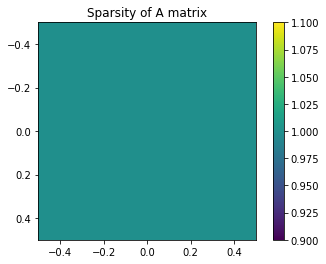

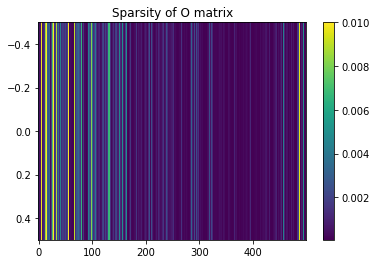

In [ ]:
hidden_states = 1
iterations = 100
shakespeare_hmm1 = unsupervised_HMM(obs, hidden_states, iterations)
generate_sonnet(obs_map, shakespeare_hmm1, np.random.choice(poss_word_lengths))
visualize_sparsities(shakespeare_hmm1, O_max_cols=500, O_vmax=0.01)

Is and that thou we hold sky there's (syllables: 8)
Pride shalt one roses they moon me is (syllables: 9)
O'erpressed worth pride virtuous single store in eloquence (syllables: 13)
Lend rich frank on men my find thy (syllables: 8)
And dead own till lest it will eternity (syllables: 11)
Be the because none the tattered being the (syllables: 10)
Therein knowledge is thee to whate'er every ruminate (syllables: 14)
Be do the office mine contented favourites so (syllables: 13)
Desire thy supposed of meet a ten hath (syllables: 11)
Till to be youth thee where to pleasing (syllables: 9)
Shaken desire love are jollity indeed that th' (syllables: 12)
Hue heaven's increase then what bestow'st you thy (syllables: 10)
  You thy prone eye thee that nature speaking (syllables: 10)
  Just praise desire put my drooping depends thou (syllables: 11)


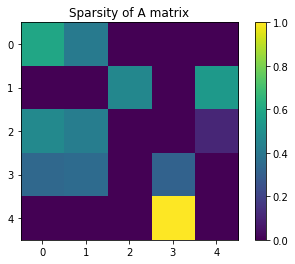

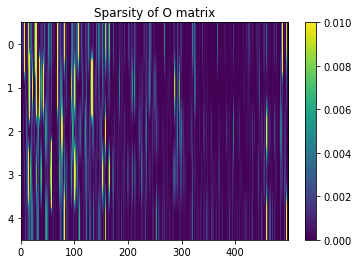

In [ ]:
hidden_states = 5
iterations = 100
shakespeare_hmm5 = unsupervised_HMM(obs, hidden_states, iterations)
generate_sonnet(obs_map, shakespeare_hmm5, np.random.choice(poss_word_lengths))
visualize_sparsities(shakespeare_hmm5, O_max_cols=500, O_vmax=0.01)

Determinate what through outstripped can refigured (syllables: 12)
Torment nought to will see bound (syllables: 7)
Love sing coward divided to come (syllables: 9)
Transferred lively with than O inheritors (syllables: 11)
Rich-proud that fair trespass hath if (syllables: 8)
To if I lets one with (syllables: 6)
Keen audit to thou own unkind (syllables: 8)
Treasure yet so of your wombs (syllables: 7)
Till in love-kindling grief out fashion (syllables: 8)
No at remedy face a journey (syllables: 9)
Disgrace moment on like no world's (syllables: 8)
A haste and paying with hands (syllables: 7)
  Sight with this O in warmed (syllables: 6)
  I flowers heart life love's of (syllables: 6)


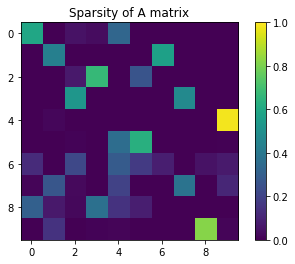

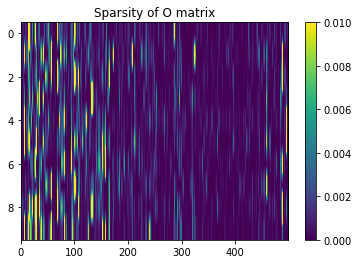

In [ ]:
hidden_states = 10
iterations = 100
shakespeare_hmm10 = unsupervised_HMM(obs, hidden_states, iterations)
generate_sonnet(obs_map, shakespeare_hmm10, np.random.choice(poss_word_lengths))
visualize_sparsities(shakespeare_hmm10, O_max_cols=500, O_vmax=0.01)

In [ ]:
hidden_states = 20
iterations = 100
shakespeare_hmm20 = unsupervised_HMM(obs, hidden_states, iterations)
generate_sonnet(obs_map, shakespeare_hmm20, np.random.choice(poss_word_lengths))

Beauty fear nor filled that the end (syllables: 8)
Keep it be go whose reproach art (syllables: 8)
Since becomes devise other knows true thy (syllables: 10)
Best revenues the desire shall loveliness less (syllables: 12)
Face for through clock newer ah fair (syllables: 8)
Sweet love fleece from less instinct than (syllables: 8)
Look me nothing bier state thou dost (syllables: 8)
Remain my tribes in my interchange kindness (syllables: 10)
And for was self in in in (syllables: 7)
Cloak o'erpressed true-telling love earth and where (syllables: 10)
What looks or created hast other of (syllables: 10)
Hath of eyes world dear me heat (syllables: 7)
  Of long doth I farewell bears shall (syllables: 8)
  I thee and say painting brand in (syllables: 8)


In [ ]:
print("Transition Matrix:")
print('#' * 70)
for i in range(len(shakespeare_hmm5.A)):
  print(''.join("{:<12.3e}".format(shakespeare_hmm5.A[i][j]) for j in range(len(shakespeare_hmm5.A[i]))))

Transition Matrix:
######################################################################
5.934e-01   4.066e-01   4.699e-24   7.734e-16   1.732e-18   
8.046e-21   3.353e-20   4.640e-01   1.959e-25   5.360e-01   
4.710e-01   4.232e-01   2.060e-20   3.492e-23   1.058e-01   
3.361e-01   3.488e-01   2.890e-19   3.151e-01   1.714e-14   
2.228e-17   1.545e-20   9.860e-04   9.990e-01   1.045e-30   


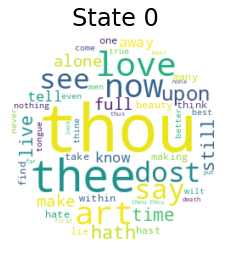

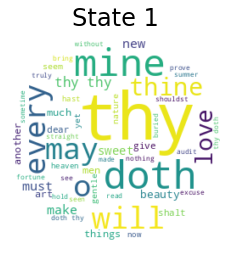

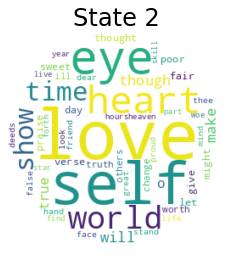

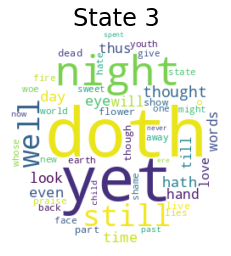

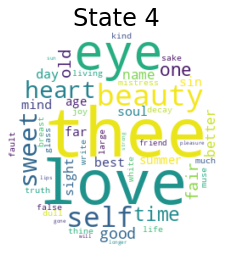

In [ ]:
shakespeare_wordclouds5 = states_to_wordclouds(shakespeare_hmm5, obs_map)

# Additional Goals

## Implement a Recurrent Model

https://colab.research.google.com/drive/1FamfS5Tz6dqc1Lhbb4tyTj7gpsmp3OOB?usp=sharing

## Meter

In [ ]:
def preprocess_punctuation_meter(total_sonnets):

  # first, get all the word sequences without the punctuation taken into account + lowercase
  input_seq = []
  punc = {',', '.', '?', '!', ':', ';', ')'}

  words = []
  for sonnet in total_sonnets:
    update_sonnet = []

    for l_ in sonnet:
      for w_ in l_.split():
        w = w_
        if w_[0] == '(':
          w_ = w_[1:]
        if w_[-1] in punc:
            w_ = w_[:-1]
        if w_[0] == "'" and w_[1:].lower() not in ['gainst', 'greeing', 'scaped', 'tis', 'twixt']:
          w_ = w_[1:]
        if w_[-1] == "'" and w_[:-1].lower() not in ['t', 'th']:
            w_ = w_[:-1]
        if w_[-1] in punc:
            w_ = w_[:-1]

        if w_.lower() in all_dictionary.keys() and is_stressed_word(w_.lower()):
          if (w_.lower() not in words):
            words.append(w_.lower())
          update_sonnet.append(w_.lower())

    input_seq.append(update_sonnet)

  word_idx = {}
  for i in range(len(words)):
    word_idx[words[i]] = i

  new_i = len(words)
  for i in range(len(input_seq)):
    for j in range(len(input_seq[i])):
      temp = input_seq[i][j]
      input_seq[i][j] = word_idx[temp]

  return  input_seq, word_idx, words

In [ ]:
def sample_sentence_sonnet (hmm, obs_map, n_syllables, syllable_dictionary, all_dict, seed=None):
  # Get reverse map.
  obs_map_r = obs_map_reverser(obs_map)

  # Sample and convert sentence.
  emission, states = hmm.generate_emission_sonnet(n_syllables, syllable_dictionary, obs_map, all_dict, seed=seed)
  sentence = [obs_map_r[i] for i in emission]

  return ' '.join(sentence).capitalize()

In [ ]:
def generate_sonnet_syllables(obs_map, hmm, words):
  word_dict = load_syllable_dictionary()
  for word in words:
    if word not in word_dict.keys():
      word_dict[word] = [[extra_count_syllables(all_dictionary[word][0])], []]
  syllables = [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
  for line in range(len(syllables)):
    sonnet = ""
    sentence = sample_sentence_sonnet(hmm, obs_map, syllables[line], word_dict, all_dictionary)
    split_sentence = sentence.split(" ")
    num_syllables = 0
    for i in range(len(split_sentence)):
      word = split_sentence[i]
      if word == "i" or word == "o":
        sonnet += word.capitalize() + " "
      else:
        sonnet += word + " "
    if line == 12 or line == 13:
      print("  ", end = '')
    print(sonnet)

In [ ]:
obs, obs_map, words = preprocess_punctuation_meter(load_shakespeare_data())

In [ ]:
hidden_states = 5
iterations = 100
sonnet_hmm5 = unsupervised_HMM(obs, hidden_states, iterations)
generate_sonnet_syllables(obs_map, sonnet_hmm5, words)

Earth your thou store's all doth will is my hath 
This be eye by most random by heaven his 
Thee all thereby jacks thou my thinks it stand 
Me in as sum thou that come which before 
As thou words beauty epitaph to the 
Meant all but verse mind straight in are but though 
Where why her precious silent this coming 
Thoughts manner made song sight thy feel still do 
All beauty shall see to former can fear 
Want self creature thy from deserts general 
Green my whether take him place when would on ill 
Motion but awards dear while and of a 
  Not then he's in party in might smell it 
  And thee a is of my a in gentle 


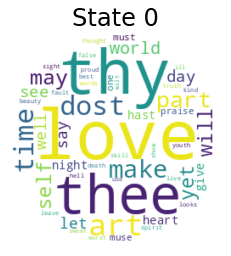

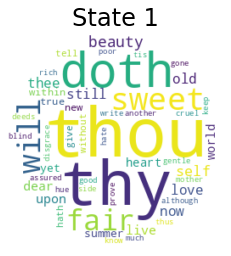

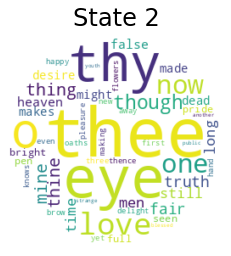

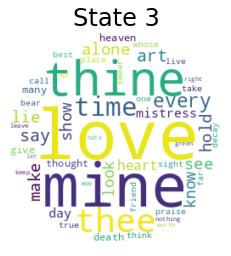

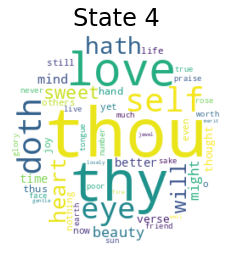

In [ ]:
sonnet_wordclouds5 = states_to_wordclouds(sonnet_hmm5, obs_map)

## Generating Other Poetic Forms (Haiku)


In [ ]:
def sample_sentence_haiku (hmm, obs_map, n_syllables, syllable_dictionary, seed=None):
  # Get reverse map.
  obs_map_r = obs_map_reverser(obs_map)

  # Sample and convert sentence.
  emission, states = hmm.generate_emission_haiku(n_syllables, syllable_dictionary, obs_map, seed=seed)
  sentence = [obs_map_r[i] for i in emission]

  return ' '.join(sentence).capitalize()

In [ ]:
def generate_haiku (obs_map, hmm, words):
  word_dict = load_syllable_dictionary()
  for word in words:
    if word not in word_dict.keys():
      word_dict[word] = [[extra_count_syllables(all_dictionary[word][0])], []]
  syllables = [5, 7, 5]
  for line in range(len(syllables)):
    sonnet = ""
    sentence = sample_sentence_haiku(hmm, obs_map, syllables[line], word_dict)
    split_sentence = sentence.split(" ")
    num_syllables = 0
    for i in range(len(split_sentence)):
      word = split_sentence[i]
      if word == "i" or word == "o":
        sonnet += word.capitalize() + " "
      else:
        sonnet += word + " "
    print(sonnet)

In [ ]:
obs, obs_map, words = preprocess_punctuation(load_spenser_and_shakespeare_data())

In [ ]:
hidden_states = 5
iterations = 100
haiku_hmm5 = unsupervised_HMM(obs, hidden_states, iterations)
generate_haiku(obs_map, haiku_hmm5, words)

Is you those fair self 
Aloft at unkind tibey to 
Love whose book not to 


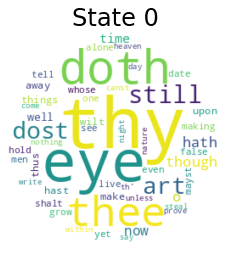

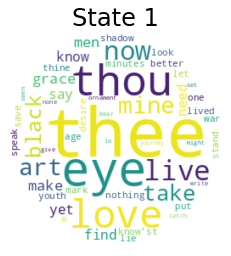

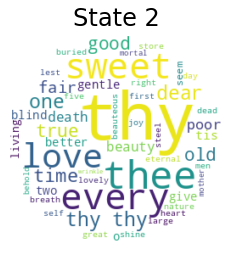

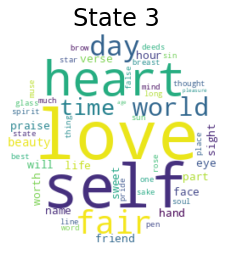

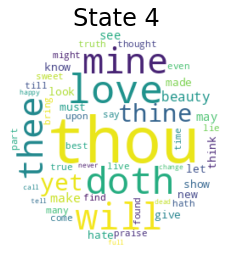

In [ ]:
haiku_wordclouds5 = states_to_wordclouds(haiku_hmm5, obs_map)